# Data Science Assignement Part 2 B2

#### Before implementing the code, it is necessary to install and import all required dependencies.

In [ ]:
#Download and install the necessary packages
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install datasets
%pip install scikit-learn
%pip install gensim
%pip install openai

In [39]:
#Import the necessary packages
from collections import Counter
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from openai import OpenAI

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  silhouette_samples, normalized_mutual_info_score

### Having installed and imported all the necessary dependencies, we can now proceed to load our data and create our dataframes

In [40]:
#Load dataset
dataset = load_dataset("DominusTea/GreekLegalSum")
full_data = dataset["train"]
df = full_data.to_pandas()

#First split: 60% train, 40% temp
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)

#Second split: 10% val and 30% test
val_df, test_df = train_test_split(temp_df, test_size=0.75, random_state=42, shuffle=True)

# Print shapes to verify
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (5037, 5)
Validation shape: (839, 5)
Test shape: (2519, 5)


### We will now explore and visualize the data for a clearer understanding

In [41]:
#Unique case categories
unique_categories = train_df['case_category'].nunique()
print(f"Number of unique case categories: {unique_categories}")
print("Distinct case categories:")
print(train_df['case_category'].value_counts())

Number of unique case categories: 315
Distinct case categories:
case_category
Αιτιολογίας επάρκεια                                         945
Αιτιολογίας ανεπάρκεια                                       498
Ακυρότητα απόλυτη                                            495
Κανονισμός αρμοδιότητας                                      116
Αναιρέσεως απαράδεκτο                                        111
Επανάληψη διαδικασίας                                         99
Υπέρβαση εξουσίας                                             80
Προθεσμία                                                     78
Ακροάσεως έλλειψη                                             63
Αοριστία λόγου αναιρέσεως                                     62
Έκδοση                                                        61
Σύμβαση εξαρτημένης εργασίας                                  47
Χρησικτησία                                                   43
Παραίτηση                                                     35
Εφέσεως απαρ

#### Plot the top 20 categories

C:\Users\Giannis\AppData\Local\Temp\ipykernel_19032\2896759199.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_counts.values, y=combined_counts.index, palette='viridis')


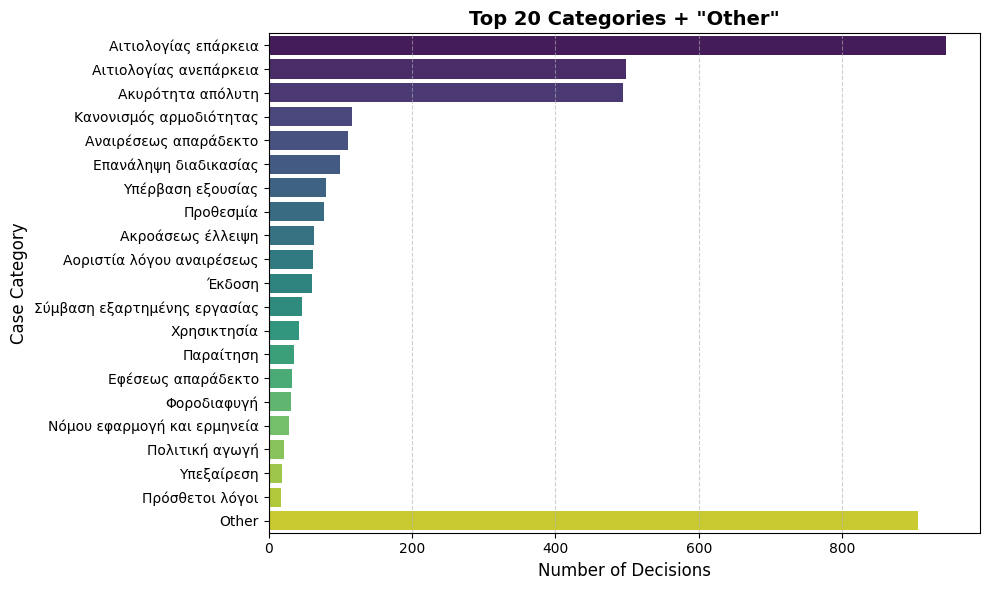

In [42]:
#Get category counts
category_counts = train_df['case_category'].value_counts()

#Top N + "Other"
top_n = 20
top_categories = category_counts.head(top_n)
other_count = category_counts[top_n:].sum()

#Combine using pd.concat (append is deprecated in pandas >= 2.0)
combined_counts = pd.concat([top_categories, pd.Series({'Other': other_count})])

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_counts.values, y=combined_counts.index, palette='viridis')
plt.title(f'Top {top_n} Categories + "Other"', fontsize=14, weight='bold')
plt.xlabel('Number of Decisions', fontsize=12)
plt.ylabel('Case Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Plot the distribution of text lengths

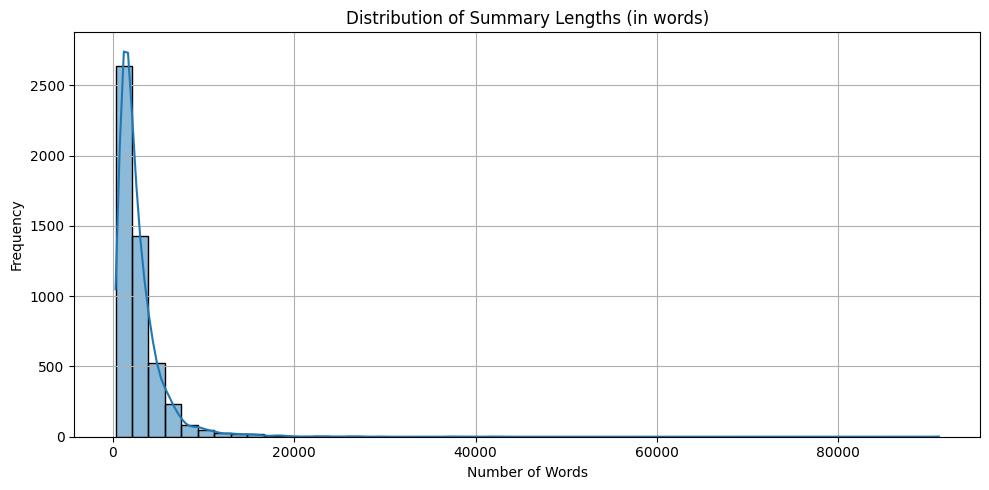

In [43]:
#Distribution of text lengths
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))

#Plot
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title("Distribution of Summary Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Plot the distribution of summary lengths

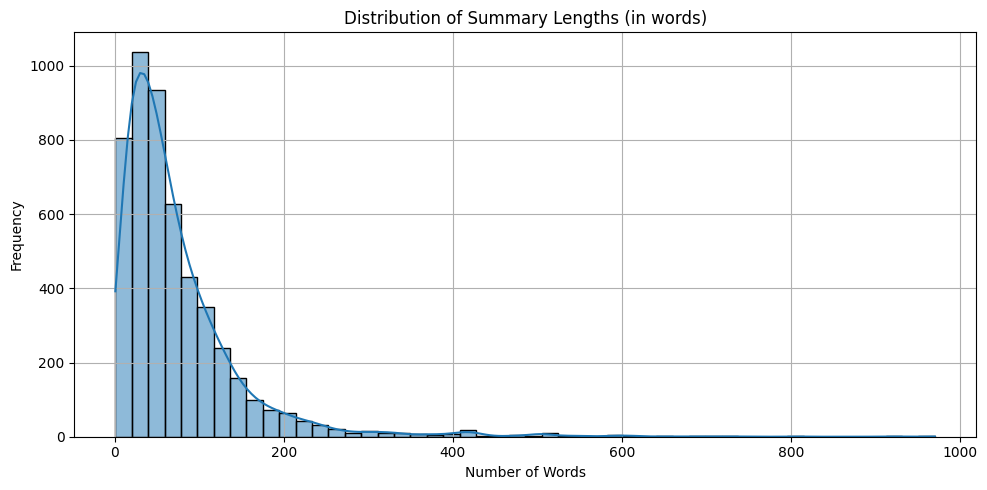

In [44]:
#Distribution of summary lengths
train_df['summary_length'] = train_df['summary'].apply(lambda x: len(str(x).split()))

#Plot
plt.figure(figsize=(10, 5))
sns.histplot(train_df['summary_length'], bins=50, kde=True)
plt.title("Distribution of Summary Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

### We can now proceed to implement the K-means algorithm

In [45]:
#Function to run the KMeans model with the following configuration
def run_KMeans(train_df, text_column='summary', n_components=500, k_range=range(2, 21)):
    #Preprocessing
    texts = train_df[text_column].fillna("").astype(str)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_tfidf = vectorizer.fit_transform(texts)

    #Dimensionality Reduction with SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)

    #Category labels
    true_categories = LabelEncoder().fit_transform(train_df['case_category'].astype(str))

    #Clean tag labels
    def parse_tags(tag_str):
        if not isinstance(tag_str, str):
            return []
        return [tag.strip() for tag in tag_str.split(',') if tag.strip()]

    tag_lists = train_df['case_tags'].fillna("[]").apply(parse_tags)
    first_tag_labels = tag_lists.apply(lambda tags: tags[0] if tags else 'None')
    tag_counts = Counter(first_tag_labels)
    first_tag_labels = first_tag_labels.apply(lambda tag: tag if tag_counts[tag] >= 10 else 'Other')
    first_tag_encoded = LabelEncoder().fit_transform(first_tag_labels)

    #Evalute clustering
    k_range = k_range
    macro_sil_scores = []
    micro_sil_scores = []
    nmi_category_scores = []
    nmi_tag_scores = []

    print("Evaluating K-means clustering over different values of K...\n")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        clusters = kmeans.fit_predict(X_reduced)

        sil_all = silhouette_samples(X_reduced, clusters)
        sil_macro = np.mean([sil_all[clusters == c].mean() for c in np.unique(clusters)])
        sil_micro = sil_all.mean()
        nmi_cat = normalized_mutual_info_score(true_categories, clusters)
        nmi_tag = normalized_mutual_info_score(first_tag_encoded, clusters)

        macro_sil_scores.append(sil_macro)
        micro_sil_scores.append(sil_micro)
        nmi_category_scores.append(nmi_cat)
        nmi_tag_scores.append(nmi_tag)

        print(f"K={k:<2} | Silhouette_macro={sil_macro:.4f} | Silhouette_micro={sil_micro:.4f} | "
            f"NMI_Category={nmi_cat:.4f} | NMI_Tag={nmi_tag:.4f}")

    #Print results
    print("\n=== Best K Results ===")
    print(f"Best K by Macro Silhouette:       K = {k_range[np.argmax(macro_sil_scores)]} → Score = {max(macro_sil_scores):.4f}")
    print(f"Best K by Micro Silhouette:       K = {k_range[np.argmax(micro_sil_scores)]} → Score = {max(micro_sil_scores):.4f}")
    print(f"Best K by NMI (case_category):    K = {k_range[np.argmax(nmi_category_scores)]} → Score = {max(nmi_category_scores):.4f}")
    print(f"Best K by NMI (first_tag):        K = {k_range[np.argmax(nmi_tag_scores)]} → Score = {max(nmi_tag_scores):.4f}")

    #Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(k_range, macro_sil_scores, marker='o', label='Silhouette Score (Macro)')
    plt.plot(k_range, micro_sil_scores, marker='x', label='Silhouette Score (Micro)')
    plt.plot(k_range, nmi_category_scores, marker='s', label='NMI Categories')
    plt.plot(k_range, nmi_tag_scores, marker='^', label='NMI First Tag')
    plt.title(f"K-means Clustering Evaluation Metrics for {text_column}", fontsize=14, weight='bold')
    plt.xlabel("Number of Clusters (K)", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.xticks(k_range)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Run the K-means for the the texts

Evaluating K-means clustering over different values of K...

K=2  | Silhouette_macro=0.0627 | Silhouette_micro=0.0997 | NMI_Category=0.1254 | NMI_Tag=0.1506
K=3  | Silhouette_macro=0.0304 | Silhouette_micro=0.0548 | NMI_Category=0.2331 | NMI_Tag=0.2541
K=4  | Silhouette_macro=0.0326 | Silhouette_micro=0.0585 | NMI_Category=0.2633 | NMI_Tag=0.2711
K=5  | Silhouette_macro=0.0432 | Silhouette_micro=0.0538 | NMI_Category=0.2827 | NMI_Tag=0.2878
K=6  | Silhouette_macro=0.0342 | Silhouette_micro=0.0275 | NMI_Category=0.2793 | NMI_Tag=0.2781
K=7  | Silhouette_macro=0.0644 | Silhouette_micro=0.0385 | NMI_Category=0.2703 | NMI_Tag=0.2677
K=8  | Silhouette_macro=0.1079 | Silhouette_micro=0.0777 | NMI_Category=0.3281 | NMI_Tag=0.3447
K=9  | Silhouette_macro=0.0866 | Silhouette_micro=0.0741 | NMI_Category=0.3439 | NMI_Tag=0.3443
K=10 | Silhouette_macro=0.1085 | Silhouette_micro=0.0679 | NMI_Category=0.3208 | NMI_Tag=0.3145
K=11 | Silhouette_macro=0.1036 | Silhouette_micro=0.0678 | NMI_Category=0.3

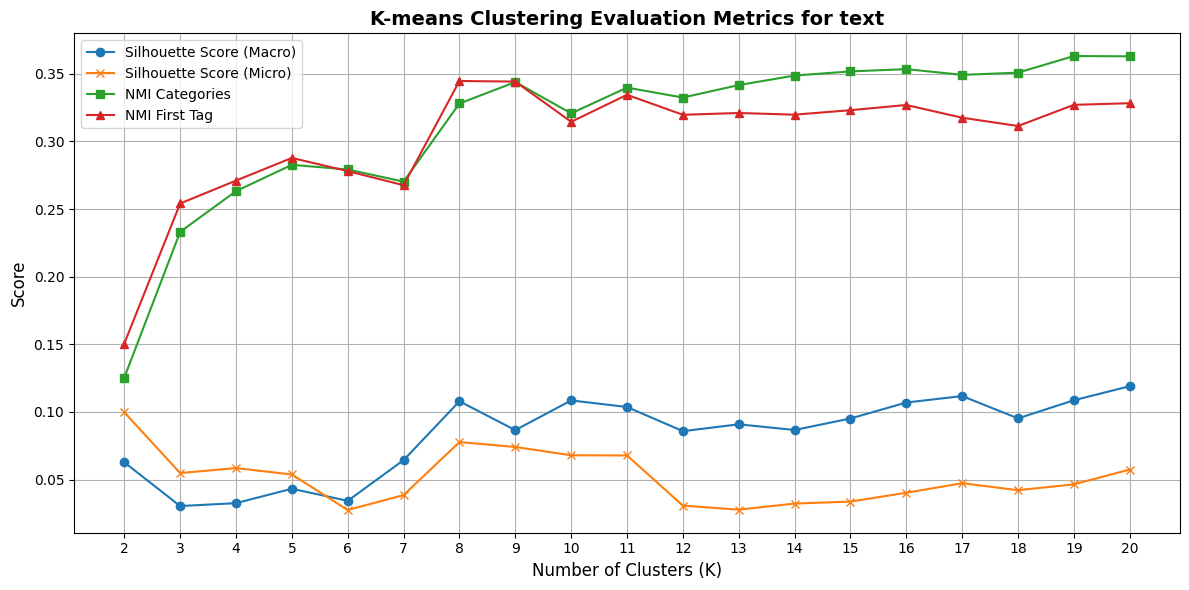

In [46]:
run_KMeans(train_df, text_column='text')

#### Run the K-means for the summary of the texts

Evaluating K-means clustering over different values of K...

K=2  | Silhouette_macro=0.0200 | Silhouette_micro=0.0252 | NMI_Category=0.0710 | NMI_Tag=0.0686
K=3  | Silhouette_macro=0.0382 | Silhouette_micro=0.0146 | NMI_Category=0.0597 | NMI_Tag=0.0391
K=4  | Silhouette_macro=0.1837 | Silhouette_micro=0.0282 | NMI_Category=0.0732 | NMI_Tag=0.0582
K=5  | Silhouette_macro=0.1459 | Silhouette_micro=0.0318 | NMI_Category=0.1402 | NMI_Tag=0.1385
K=6  | Silhouette_macro=0.1509 | Silhouette_micro=0.0327 | NMI_Category=0.1592 | NMI_Tag=0.1505
K=7  | Silhouette_macro=0.1096 | Silhouette_micro=0.0226 | NMI_Category=0.1900 | NMI_Tag=0.1680
K=8  | Silhouette_macro=0.0960 | Silhouette_micro=0.0239 | NMI_Category=0.1934 | NMI_Tag=0.1858
K=9  | Silhouette_macro=0.0858 | Silhouette_micro=0.0232 | NMI_Category=0.2593 | NMI_Tag=0.2409
K=10 | Silhouette_macro=0.0798 | Silhouette_micro=0.0219 | NMI_Category=0.2468 | NMI_Tag=0.2220
K=11 | Silhouette_macro=0.1118 | Silhouette_micro=0.0225 | NMI_Category=0.2

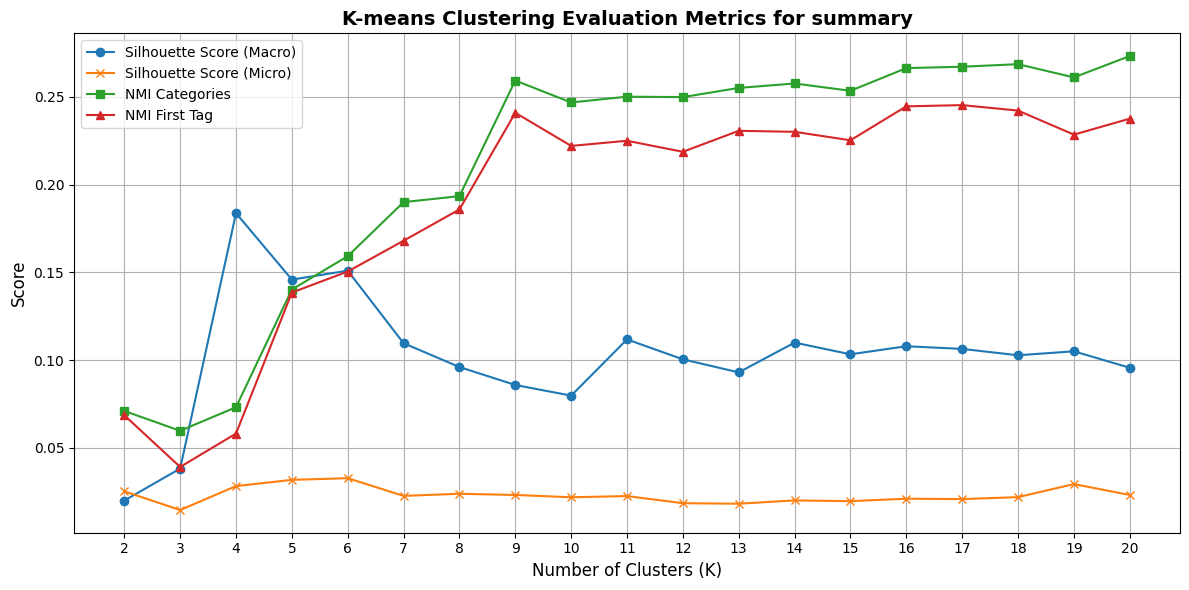

In [47]:
run_KMeans(train_df, text_column='summary')

### Now we are going to use an LLM to extract the titles

#### Setup what needed for the LLM

In [ ]:
# Load and reset training data
train_df = train_df.reset_index(drop=True)
results = []

# Vectorize summaries with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df["summary"].fillna(""))

# Run K-means clustering with K = 20 (best K for summary based on NMI)
kmeans = KMeans(n_clusters=20, random_state=42)
train_df["cluster"] = kmeans.fit_predict(X_tfidf)

# Set up OpenRouter client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=""  
)

#### Create the necessary functions to run the LLM

In [49]:
# Get the centroid for every cluster
def get_centroid_samples(X, df, cluster_id, n=3):
    cluster_indices = df[df['cluster'] == cluster_id].index
    cluster_points = X[cluster_indices]
    centroid = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    closest_indices = cluster_indices[np.argsort(distances)[:n]]
    return df.loc[closest_indices]

# Get random sample for every cluster
def get_random_samples(df, cluster_id, n=3):
    return df[df['cluster'] == cluster_id].sample(n)

# Create the LLM prompt
def create_llm_prompt(decisions):
    prompt = (
        "Σου δίνονται αποσπάσματα από νομικές αποφάσεις του Αρείου Πάγου.\n"
        "Ποιο είναι το βασικό νομικό θέμα που προκύπτει από τα κείμενα;\n"
        "Απάντησε με τη μορφή: 'Θέμα:\\n...'\n\n"
    )
    for _, row in decisions.iterrows():
        prompt += f"Το κείμενο είναι το εξής:\n{row['summary']}\n\n"
    return prompt

# Send the prompt to LLM
def query_llm_openrouter(prompt):
    messages = [
        {"role": "system", "content": "Είσαι βοηθός νομικής ανάλυσης αποφάσεων."},
        {"role": "user", "content": prompt}
    ]
    response = client.chat.completions.create(
        model="meta-llama/llama-4-maverick:free",  
        messages=messages,
        max_tokens=256,
        temperature=0.7,
    )
    return response.choices[0].message.content

# Extract the topic from LLM
def extract_topic(response):
    match = re.search(r"Θέμα:\s*(.+)", response, re.IGNORECASE)
    return match.group(1).strip() if match else "Δεν εντοπίστηκε θέμα"

# Analyze all clusters
def analyze_clusters_with_llm(X_tfidf, df, num_clusters=20, delay=3):
    results = []
    for cluster_id in range(num_clusters):
        print(f"Processing cluster {cluster_id}...")

        try:
            random_samples = get_random_samples(df, cluster_id)
            prompt_random = create_llm_prompt(random_samples)
            response_random = query_llm_openrouter(prompt_random)
            topic_random = extract_topic(response_random)
        except Exception as e:
            topic_random = f"Σφάλμα: {e}"

        try:
            centroid_samples = get_centroid_samples(X_tfidf, df, cluster_id)
            prompt_centroid = create_llm_prompt(centroid_samples)
            response_centroid = query_llm_openrouter(prompt_centroid)
            topic_centroid = extract_topic(response_centroid)
        except Exception as e:
            topic_centroid = f"Σφάλμα: {e}"

        results.append({
            "cluster_id": cluster_id,
            "topic_random": topic_random,
            "topic_centroid": topic_centroid
        })

        time.sleep(delay)   # Add a little delay to not exceed the rate limit

    topics_df = pd.DataFrame(results)
    return topics_df

#### Run the LLM for every cluster and extract the results

In [50]:
topics_df = analyze_clusters_with_llm(X_tfidf, train_df, num_clusters=20)

Processing cluster 0...
Processing cluster 1...
Processing cluster 2...
Processing cluster 3...
Processing cluster 4...
Processing cluster 5...
Processing cluster 6...
Processing cluster 7...
Processing cluster 8...
Processing cluster 9...
Processing cluster 10...
Processing cluster 11...
Processing cluster 12...
Processing cluster 13...
Processing cluster 14...
Processing cluster 15...
Processing cluster 16...
Processing cluster 17...
Processing cluster 18...
Processing cluster 19...


#### Display the results 

In [51]:
display(topics_df)

,cluster_id,topic_random,topic_centroid
0,0,Η έλλειψη αιτιολογίας σε δικαστικές αποφάσεις και η επίδρασή της στην αναίρεση τους.,Η έλλειψη αιτιολογίας σε δικαστικές αποφάσεις ως λόγος αναίρεσης.
1,1,"Το βασικό νομικό θέμα που προκύπτει από τα κείμενα είναι η παραδεκτή ή μη αίτηση αναίρεσης σε διάφορες περιπτώσεις (ερήμην αναιρεσειόντων, κατά διάταξης του Εισαγγελέα Εφετών, κατά βουλεύματος Συμβουλίου Εφετών).",Το βασικό νομικό θέμα που προκύπτει από τα κείμενα είναι η αναίρεση κατά βουλεύματος Συμβουλίου Εφετών που αφορά την έφεση κατά πρωτοβάθμιου παραπεμπτικού βουλεύματος και συγκεκριμένα η δυνατότητα ή μη υποβολής αίτησης αναίρεσης κατά τέτοιων βουλευμάτων.
2,2,"Τα κείμενα αφορούν νομικές αποφάσεις του Αρείου Πάγου σχετικά με την έκδοση ακάλυπτων επιταγών και τις διαδικαστικές προϋποθέσεις για την άσκηση ποινικής δίωξης. Συγκεκριμένα, θίγουν θέματα όπως η έλλειψη αιτιολογίας στις αποφάσεις των κατωτέρων δικαστηρίων, η εγκυρότητα της εγκλήσεως της παθούσας εταιρίας και το έγκλημα της εκδόσεως ακάλυπτης επιταγής.","Το βασικό νομικό θέμα που προκύπτει από τα κείμενα αφορά την ερμηνεία και εφαρμογή των διατάξεων περί επιταγής, ιδίως όσον αφορά την υποβολή εγκλήσεως για έκδοση ακάλυπτης επιταγής, την ταυτότητα του δικαιούχου της εγκλήσεως, και τις προϋποθέσεις για την ποινική δίωξη του εκδότη της επιταγής."
3,3,"Το βασικό νομικό θέμα που προκύπτει από τα κείμενα είναι η διαδικασία και οι προϋποθέσεις άσκησης αιτήσεων αναιρέσεως κατά αποφάσεων των δικαστηρίων, καθώς και οι λόγοι που οδηγούν στην απόρριψη ή την κήρυξη απαράδεκτης μιας τέτοιας αίτησης.",Η παραδεκτότητα των αιτήσεων αναίρεσης κατά αποφάσεων του Αρείου Πάγου.
4,4,"Τα κείμενα αναφέρονται σε αποφάσεις του Αρείου Πάγου που αφορούν ποικίλα νομικά ζητήματα, όπως η αρχή της χειροτέρευσης της θέσης του κατηγορουμένου στο πλαίσιο του Ποινικού Δικαίου, η ερμηνεία διατάξεων σχετικά με τις εισφορές στο ΙΚΑ και η εφαρμογή των ερμηνευτικών κανόνων για τις δικαιοπραξίες, ειδικότερα σε σχέση με πρόσυμφωνο πώλησης και την ερμηνεία όρων που αφορούν το δικαίωμα υπαναχώρησης.","Τα δύο κείμενα αναφέρονται σε ποινικά θέματα, με το πρώτο να αφορά την εφαρμογή του ευρωπαϊκού εντάλματος σύλληψης και την εκτέλεση αυτού βάσει του Ν. 3251/2004, ενώ το δεύτερο κείμενο αναφέρεται σε ζητήματα ποινικού δικαίου σχετικά με την εισαγωγή και μεταφορά ναρκωτικών, τη σύμπραξη, τον κοινό δόλο και την ειδική αιτιολογία στις ποινικές αποφάσεις."
5,5,"Τα κείμενα πραγματεύονται θέματα ποινικού δικαίου, συγκεκριμένα τις έννοιες και τις επιπτώσεις της ψευδούς καταμήνυσης, της ψευδορκίας και της συκοφαντικής δυσφήμησης, καθώς και ζητήματα αιτιολογίας των αποφάσεων και διαδικαστικών θεμάτων όπως η παραγραφή της αξιώσεως και η μεταβίβαση αυτής.","Το βασικό νομικό θέμα που προκύπτει από τα κείμενα αφορά την έλλειψη αιτιολογίας σε καταδικαστικές αποφάσεις για τα αδικήματα της ψευδούς καταμηνύσεως, της ψευδορκίας μαρτύρων, καθώς και της ηθικής αυτουργίας στην ψευδορκία, και συγκεκριμένα την απαίτηση για ειδική και εμπεριστατωμένη αιτιολογία σχετικά με τα στοιχεία δόλου και γνώσης ψεύδους στα εν λόγω αδικήματα."
6,6,"Κανονισμός Αρμοδιότητας Δικαστηρίων για υποθέσεις που αφορούν δικαστικούς και εισαγγελείς, με βάση το άρθρο 136 ΚΠΔ.",Κανονισμός αρμοδιότητας δικαστηρίων.
7,7,"Τα κείμενα αφορούν ποινικές υποθέσεις και εξετάζουν ζητήματα όπως η ορθή ερμηνεία και εφαρμογή του ποινικού νόμου, η αξιολόγηση των αποδείξεων, η διαδικασία των δικαστικών αποφάσεων και η νομιμότητα των δικαστικών αποφάσεων του Συμβουλίου Εφετών και του Αρείου Πάγου, σε σχέση με αξιόποινες πράξεις όπως η τοκογλυφία και η υπεξαίρεση.","Το βασικό νομικό θέμα που προκύπτει από τα κείμενα αφορά την απάτη κατ' εξακολούθηση και κατ' επάγγελμα, καθώς και την ερμηνεία και εφαρμογή σχετικών ποινικών διατάξεων, περιλαμβάνοντας ζητήματα όπως η συναυτουργία, η ειδική και εμπεριστατωμένη αιτιολογία των δικαστικών αποφάσεων, και η απόλυτη ακυρότητα."
8,8,"Το βασικό νομικό θέμα που προκύπτει από τα κείμενα αφορά το παραδεκτό της ασκήσεως αναίρεσης κατά αποφάσεων